# Modélisation baseline — Prévision de la demande énergétique

Ce notebook présente la démarche de modélisation baseline pour la prévision de la demande, en utilisant plusieurs modèles classiques (régression linéaire, Ridge, Random Forest, ARIMA, etc.) sur les données traitées.

## 1. Imports et configuration

In [1]:
from dotenv import load_dotenv
import os
load_dotenv()
os.chdir("..")

import warnings
warnings.simplefilter("ignore")

import pandas as pd
import yaml
from pathlib import Path
import matplotlib.pyplot as plt
import joblib
from src.models.modeling import train_models_for_zone

In [2]:
def load_config(config_path: str = "config.yaml") -> dict:
    with open(config_path, "r") as f:
        cfg = yaml.safe_load(f)
    return cfg

cfg = load_config("config.yaml")
processed_dir = Path(cfg["paths"]["data"]["processed"])
models_dir    = Path("models")
reports_dir   = Path("outputs/reports")
models_dir.mkdir(exist_ok=True, parents=True)
reports_dir.mkdir(exist_ok=True, parents=True)
zones = list(cfg["geo_zones"].values())

## 2. Entraînement des modèles baseline

In [3]:
all_metrics = []
for zone in zones:
    print(f"→ Training {zone}")
    res = train_models_for_zone(zone, processed_dir, models_dir)
    flat = {"zone": zone}
    for h, mets in res.items():
        for m, vals in mets.items():
            flat[f"{h}_{m}_MAE"]  = vals["MAE"]
            flat[f"{h}_{m}_RMSE"] = vals["RMSE"]
            flat[f"{h}_{m}_MAPE"] = vals["MAPE"]
    all_metrics.append(flat)

→ Training Peninsule_Iberique
MAE: 2.93, RMSE: 3.81, MAPE: 0.00%
MAE: 0.00, RMSE: 0.00, MAPE: 0.00%
MAE: 2.93, RMSE: 3.81, MAPE: 0.00%
MAE: 0.00, RMSE: 0.00, MAPE: 0.00%
MAE: 1323360.74, RMSE: 1654545.06, MAPE: 23.97%
MAE: 1323360.74, RMSE: 1654545.06, MAPE: 23.97%
MAE: 3526285.71, RMSE: 3622828.71, MAPE: 75.49%
MAE: 3526285.71, RMSE: 3622828.71, MAPE: 75.49%
MAE: 8616.22, RMSE: 18834.53, MAPE: inf%
MAE: 8616.22, RMSE: 18834.53, MAPE: inf%
MAE: 8616.22, RMSE: 18834.53, MAPE: inf%
MAE: 8616.22, RMSE: 18834.53, MAPE: inf%
MAE: 6872.01, RMSE: 14591.13, MAPE: 3.65%
→ Training Baleares
MAE: 6872.01, RMSE: 14591.13, MAPE: 3.65%
→ Training Baleares
MAE: 1109.25, RMSE: 2185.75, MAPE: 37.58%
MAE: 1097.67, RMSE: 2171.46, MAPE: 37.76%
MAE: 1109.25, RMSE: 2185.75, MAPE: 37.58%
MAE: 1097.67, RMSE: 2171.46, MAPE: 37.76%
MAE: 1228.54, RMSE: 2695.57, MAPE: 45.23%
MAE: 1228.54, RMSE: 2695.57, MAPE: 45.23%
MAE: 4901.71, RMSE: 5890.65, MAPE: 113.45%
MAE: 4901.71, RMSE: 5890.65, MAPE: 113.45%
MAE: 22.50, 

In [4]:
# Sauvegarde des métriques
pd.DataFrame(all_metrics).to_csv(
    reports_dir/"all_zones_baseline_metrics.csv", index=False
)

## 3. Visualisation des performances sur la période test

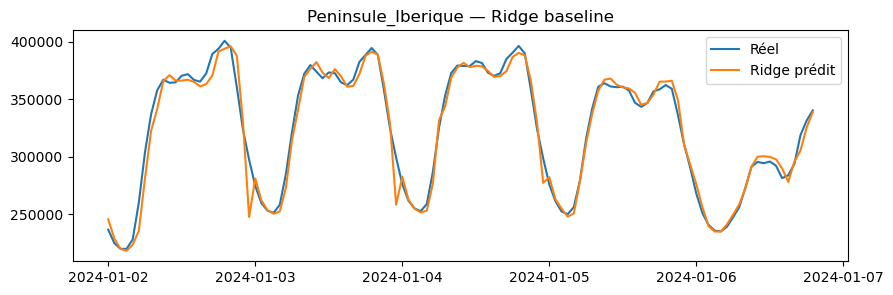

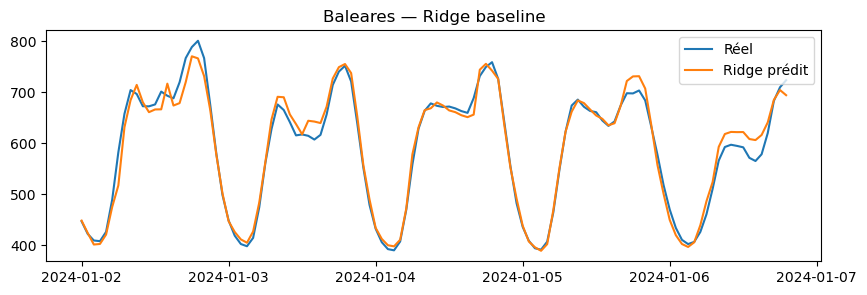

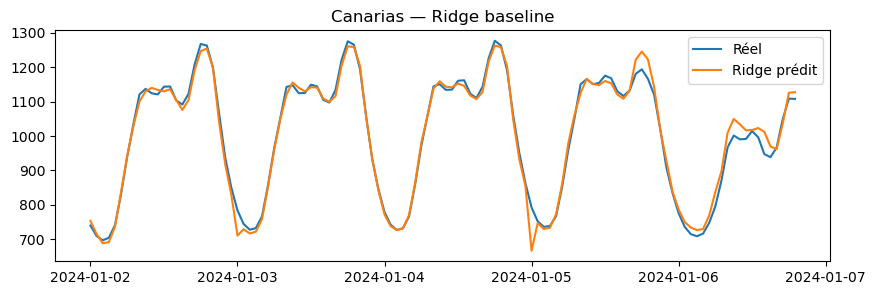

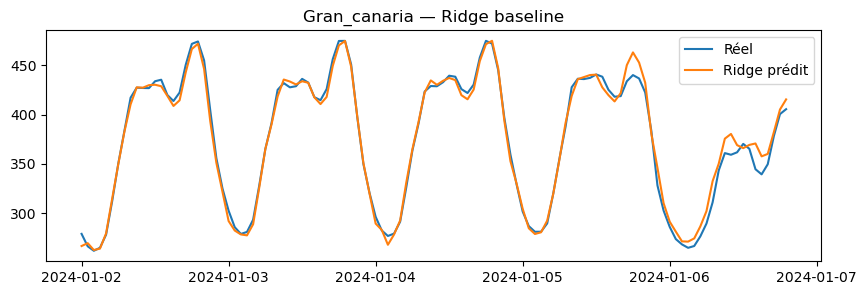

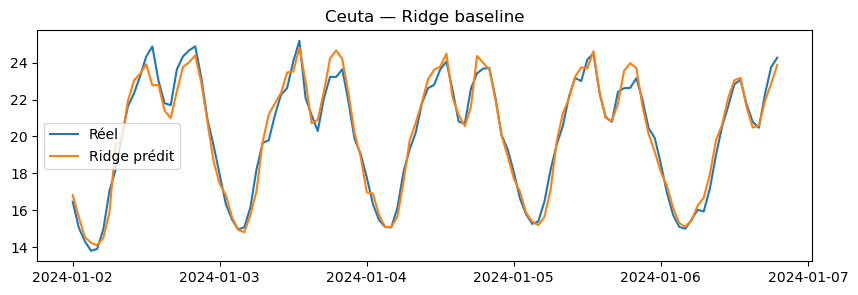

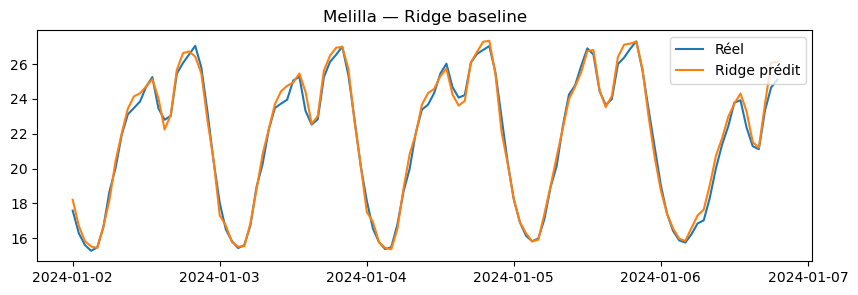

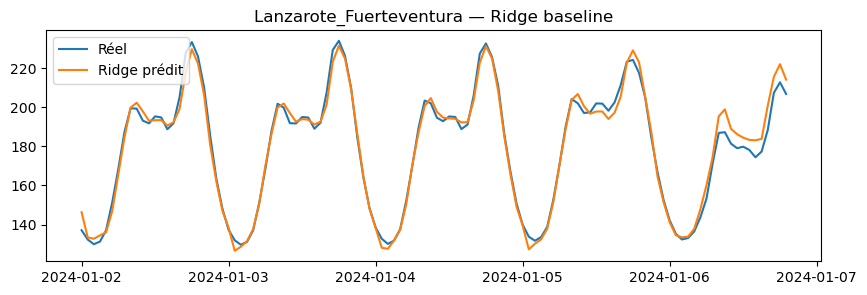

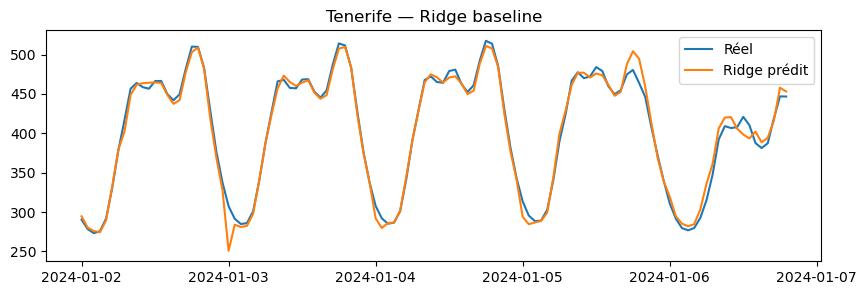

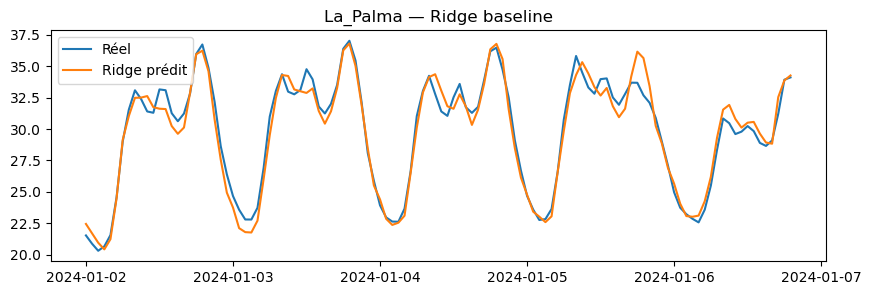

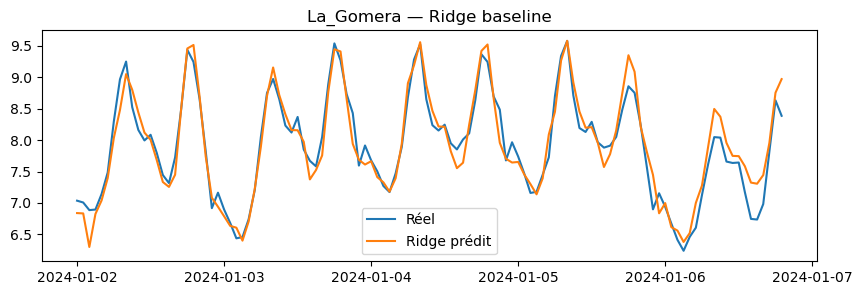

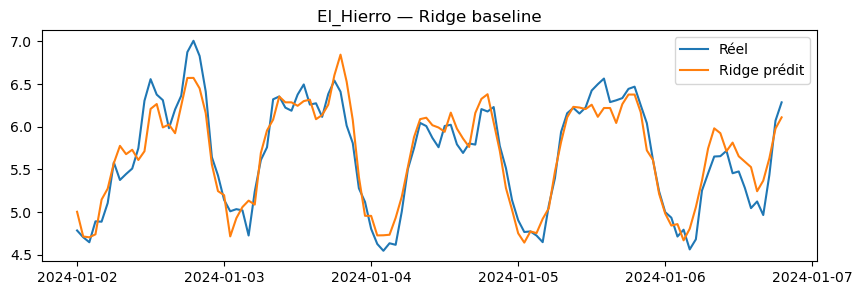

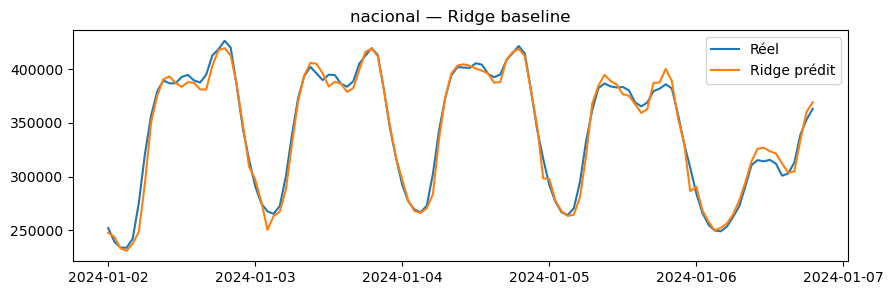

In [17]:
for zone in zones:
    df = pd.read_parquet(Path(cfg["paths"]["data"]["submission"])/f"{zone}_processed_hourly.parquet")
    test = df["demand"].iloc[:int(len(df)*0.01)]
    model_rf = joblib.load(models_dir/f"{zone}_hourly_rf.pkl")
    pred = model_rf.predict(df.drop(columns="demand").iloc[:int(len(df)*0.01)])
    plt.figure(figsize=(10,3))
    plt.plot(test.index, test, label="Réel")
    plt.plot(test.index, pred, label="Ridge prédit")
    plt.title(f"{zone} — Ridge baseline")
    plt.legend()
    plt.show()

## 4. Analyse des métriques globales

In [6]:
metrics_df = pd.read_csv(reports_dir/"all_zones_baseline_metrics.csv")
display(metrics_df.head())
metrics_df.describe().T

,zone,daily_ElasticNet_MAE,daily_ElasticNet_RMSE,daily_ElasticNet_MAPE,daily_Ridge_MAE,daily_Ridge_RMSE,daily_Ridge_MAPE,daily_RandomForest_MAE,daily_RandomForest_RMSE,daily_RandomForest_MAPE,...,hourly_ElasticNet_MAPE,hourly_Ridge_MAE,hourly_Ridge_RMSE,hourly_Ridge_MAPE,hourly_RandomForest_MAE,hourly_RandomForest_RMSE,hourly_RandomForest_MAPE,hourly_auto_arima_MAE,hourly_auto_arima_RMSE,hourly_auto_arima_MAPE
0,Peninsule_Iberique,2.925515,3.811486,0.000130,6.528057e-08,8.004906e-08,2.665267e-12,1.323361e+06,1.654545e+06,23.966231,...,inf,8616.221037,18834.533924,inf,6872.014912,14591.131479,3.651162,inf,inf,inf
1,Baleares,1109.253288,2185.750743,37.579383,1.097671e+03,2.171461e+03,3.775679e+01,1.228544e+03,2.695571e+03,45.226404,...,inf,22.500199,43.220529,inf,14.676477,32.089206,inf,inf,inf,inf
2,Canarias,0.486699,0.706406,0.009344,5.258493e-06,6.856424e-06,8.374018e-08,4.754269e+02,8.182019e+02,2.043800,...,inf,29.209899,57.334009,inf,13.791927,36.192293,inf,inf,inf,inf
3,Gran_canaria,508.940204,723.330586,23.385905,5.135484e+02,7.257926e+02,2.349680e+01,5.479397e+02,1.227753e+03,5.859668,...,inf,10.962960,21.580909,inf,5.661899,14.420467,inf,inf,inf,inf
4,Ceuta,0.014531,0.019753,0.011075,2.026905e-04,2.574188e-04,1.304486e-04,1.926567e+01,3.186517e+01,5.206202,...,inf,0.774064,1.420790,inf,0.499292,1.051687,inf,inf,inf,inf


,count,mean,std,min,25%,50%,75%,max
daily_ElasticNet_MAE,12.0,6.529194e+04,2.256522e+05,2.917551e-03,0.048314,0.361939,163.231512,7.818332e+05
daily_ElasticNet_RMSE,12.0,1.007377e+05,3.480211e+05,5.123168e-03,0.070282,0.562552,246.100271,1.205851e+06
daily_ElasticNet_MAPE,12.0,1.318195e+01,2.044347e+01,1.302055e-04,0.007674,0.088355,26.934275,5.268631e+01
daily_Ridge_MAE,12.0,6.580370e+04,2.274285e+05,6.528057e-08,0.000039,0.000455,164.286578,7.879853e+05
daily_Ridge_RMSE,12.0,1.008547e+05,3.484315e+05,8.004906e-08,0.000049,0.000601,247.019090,1.207271e+06
daily_Ridge_MAPE,12.0,1.319520e+01,2.054003e+01,2.665267e-12,0.000003,0.000899,27.061794,5.300243e+01
daily_RandomForest_MAE,12.0,1.412526e+05,3.870683e+05,5.070170e+00,38.437467,131.237763,718.090662,1.323361e+06
daily_RandomForest_RMSE,12.0,1.890886e+05,4.935428e+05,7.835975e+00,76.898474,236.665579,1594.707693,1.654545e+06
daily_RandomForest_MAPE,12.0,1.640272e+01,1.705731e+01,2.043800e+00,4.757164,7.605162,28.101844,4.522640e+01
daily_auto_arima_MAE,12.0,4.583064e+05,1.118807e+06,1.852992e+01,69.955935,696.887239,3079.661160,3.526286e+06


# Résumé et prochaines étapes

- Plusieurs modèles de base ont été entraînés et évalués sur chaque zone.
- Les métriques (MAE, RMSE, MAPE) sont sauvegardées pour chaque modèle et chaque horizon.
- Les performances sont visualisées sur la période de test.
- Prochaines étapes : affiner les features, tester des modèles avancés (LGBM, XGBoost, modèles séquentiels), intégrer les exogènes, tuning hyperparamètres, etc.